In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import joblib
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder, rotation_feature_engineer, accelrometer_feature_engineer
from src.data_cleaning import clean_df
from src.utils.model_utils import evaulate_model, train_model
from src.utils.visualize_utils import plot_cm, get_avg_fold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

from scipy.spatial.transform import Rotation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [2]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5", "tof_5_v20"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_3_v17,tof_4_v5,tof_5_v20,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,57.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,68.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,97.0,107.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,151.0,113.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,207.0,121.0,192.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,219.0,93.0,46.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,216.0,82.0,50.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,208.0,83.0,53.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,210.0,91.0,48.0,1,30,0,1,186.0,55,30.0


In [3]:
cleaned_df, target_gestures = clean_df(full_df, drop_rot_na=True, drop_thm_na=False, min_gesture_count=-1)

cleaned_df = rotation_feature_engineer(cleaned_df)
cleaned_df = accelrometer_feature_engineer (cleaned_df)

cleaned_df

[rot_na] Remaining: 254179/574945 (-320766, 55.8% dropped)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,rotvec_x_diff,rotvec_z_diff,angular_mag,fft_acc_x,fft_acc_y,fft_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z
25,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.000000,0.000000,0.000000,24206.0,16287.0,9289.0,9.924192,0.000000,0.000000,0.000000
26,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,-0.003831,-0.028692,0.030410,37.0,65.0,209.0,10.113299,-0.042969,0.117188,0.343750
27,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.032691,0.025619,0.041628,63.0,11.0,54.0,10.536305,0.042969,-0.152344,0.957031
28,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,0.050705,0.046642,0.092412,9.0,0.0,52.0,9.782531,-0.539062,0.343750,-1.187500
29,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,0.014674,0.006900,0.024087,0.0,0.0,2.0,9.925453,0.500000,0.191406,-0.765625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,0.026447,-0.035032,0.074799,1.0,2.0,32.0,9.150011,-0.078125,0.308594,0.761719
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,-0.009189,-0.039282,0.041290,4.0,2.0,0.0,9.972424,0.269531,-0.230469,-0.765625
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,-0.006959,0.001019,0.009219,14.0,0.0,13.0,8.021313,-0.691406,0.882812,1.804688
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,-0.010090,-0.038689,0.041088,4.0,0.0,8.0,9.919849,0.882812,-0.578125,-1.683594


In [75]:
agg_recipe = {
    "gesture": ["first"],
    "subject": ["first"],
    
    # ---Rotation
    "rotvec_x": ["mean", "std"],
    "rotvec_y": ["mean", "std"],
    "rotvec_z": ["mean", "std"],
    "rot_angle": ["mean", "std"],
    # angular velocity
    "rotvec_x_diff": ["mean", "std", "min", "max"],
    "rotvec_y_diff": ["mean", "std", "min", "max"],
    "rotvec_z_diff": ["mean", "std", "min", "max"],
    "angular_mag": ["mean", "std", "max"], # dont' add min here, it was always zero
    
    # ---Accelrometer
    "acc_x": ["mean", "std"],
    "acc_y": ["mean", "std"],
    "acc_z": ["mean", "std"],
    # mag
    "acc_mag": ["mean", "std"],
    # jerk
    "jerk_acc_x": ["mean", "std", "min", "max"],
    "jerk_acc_y": ["mean", "std", "min", "max"],
    "jerk_acc_z": ["mean", "std", "min", "max"],
    # fft stuff
    "fft_acc_x": ["mean", "std"],
    "fft_acc_y": ["mean", "std"],
    "fft_acc_z": ["mean", "std"],
    
    #
    "thm_2": ["mean", "std"],
    "thm_4": ["mean", "std"],
    "thm_5": ["mean", "std"],
    "thm_5": ["mean", "std"],
    "tof_1_v20": ["mean", "std"],
}

filtered_df = cleaned_df.groupby("sequence_id")[list(agg_recipe.keys())].agg(agg_recipe)  # type: ignore
filtered_df.columns = ["_".join(col).strip() if col[1] else col[0] for col in filtered_df.columns.values]
filtered_df = filtered_df.rename(
    columns={
        "gesture_first": "target",
        "subject_first": "subject",
    }
)

# encoder
target_df = filtered_df["target"]
subject_df = filtered_df["subject"]
encoder = load_encoder(encoder_path, target_df)

target_np = torch.tensor(encoder.transform(target_df), dtype=torch.long).numpy()
features_np = torch.tensor(filtered_df.drop(columns=["target", "subject"]).to_numpy(), dtype=torch.float32).contiguous().numpy()

target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

filtered_df

,target,subject,rotvec_x_mean,rotvec_x_std,rotvec_y_mean,rotvec_y_std,rotvec_z_mean,rotvec_z_std,rot_angle_mean,rot_angle_std,...,fft_acc_z_mean,fft_acc_z_std,thm_2_mean,thm_2_std,thm_4_mean,thm_4_std,thm_5_mean,thm_5_std,tof_1_v20_mean,tof_1_v20_std
sequence_id,,,,,,,,,,,,,,,,,,,,,
SEQ_000007,Cheek - pinch skin,SUBJ_059520,-0.491419,0.088411,0.646820,0.130625,0.920630,0.075947,1.237257,0.080723,...,313.968750,1638.559763,30.761249,0.485551,29.078639,0.148042,28.359300,0.513923,61.031250,32.367332
SEQ_000008,Forehead - pull hairline,SUBJ_020948,-0.481945,0.051845,0.191723,0.059166,0.908953,0.169366,1.058416,0.095239,...,574.090909,3014.997112,32.016294,1.988673,31.252343,0.365182,26.816013,0.895062,131.060606,71.269269
SEQ_000013,Cheek - pinch skin,SUBJ_040282,1.419351,0.117953,0.763822,0.086338,2.507355,0.097212,2.985374,0.047049,...,465.700000,2477.217936,24.065670,0.061293,24.664993,0.150427,24.628350,0.114652,-1.000000,0.000000
SEQ_000016,Write name on leg,SUBJ_052342,-0.978995,0.028443,2.326376,0.431889,0.863376,0.255317,2.682087,0.415276,...,819.029412,4405.039053,34.378147,2.681950,34.694450,1.245293,32.257148,2.677430,5.852941,3.798982
SEQ_000018,Forehead - pull hairline,SUBJ_032165,-2.381709,0.035173,-0.771175,0.041772,1.220128,0.044562,2.785772,0.016233,...,384.794118,2226.410248,30.334161,0.426640,28.062466,0.185449,31.859936,0.122340,140.058824,5.387647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQ_065508,Write name on leg,SUBJ_027682,0.286483,0.039557,-1.125245,0.032410,1.481904,0.021156,1.883240,0.026151,...,130.515152,741.855618,30.241228,0.250120,27.869123,0.160213,24.568769,0.114216,10.727273,46.886347
SEQ_065519,Neck - scratch,SUBJ_050642,-0.027254,0.178825,0.113071,0.080225,1.889328,0.028813,1.902616,0.033410,...,168.700000,905.507598,29.116303,0.207229,28.231606,0.228395,27.450978,0.545437,56.533333,6.652629
SEQ_065522,Above ear - pull hair,SUBJ_040282,1.258610,0.059650,-1.674419,0.047494,0.974436,0.069383,2.312136,0.040740,...,54.400000,246.400655,31.219762,0.786523,28.158508,0.275256,25.819240,0.112647,114.433333,83.756084


In [76]:
n_splits = 5
gkf = GroupKFold(n_splits)

X_test_arr = []
X_train_arr = []
y_train_arr = []
y_test_arr = []
importances = []

test_subjects = []
folds_score = []
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_np, y=target_np, groups=subject_df)): # type: ignore
    print(f"\n------FOLD {fold + 1}/5------\n")
    test_subjects.append(subject_df[test_indices].unique())
    X_train, y_train = features_np[train_indices], target_np[train_indices]
    X_test, y_test = features_np[test_indices], target_np[test_indices]
    
    lgbm = lgb.LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.1, num_leaves=31)
    lgbm.fit(X_train, y_train)
    
    X_train_arr.append(X_train)
    X_test_arr.append(X_test)
    y_train_arr.append(y_train)
    y_test_arr.append(y_test)
    
    y_pred = lgbm.predict(X_test)
    score_dashboard = evaulate_model(y_pred, y_test, target_gestures_encoded, encoder)
    importances.append(lgbm.feature_importances_)
    folds_score.append(score_dashboard)


------FOLD 1/5------

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14531
[LightGBM] [Info] Number of data points in the train set: 6486, number of used features: 57
[LightGBM] [Info] Start training from score -2.546920
[LightGBM] [Info] Start training from score -2.548890
[LightGBM] [Info] Start training from score -2.546920
[LightGBM] [Info] Start training from score -2.542991
[LightGBM] [Info] Start training from score -2.542991
[LightGBM] [Info] Start training from score -2.542991
[LightGBM] [Info] Start training from score -2.542991
[LightGBM] [Info] Start training from score -2.546920
[LightGBM] [Info] Start training from score -0.987947


/tmp/ipykernel_530462/3363204969.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_530462/3363204969.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())



------FOLD 2/5------

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14530
[LightGBM] [Info] Number of data points in the train set: 6492, number of used features: 57
[LightGBM] [Info] Start training from score -2.547844
[LightGBM] [Info] Start training from score -2.549815
[LightGBM] [Info] Start training from score -2.547844
[LightGBM] [Info] Start training from score -2.543915
[LightGBM] [Info] Start training from score -2.543915
[LightGBM] [Info] Start training from score -2.543915
[LightGBM] [Info] Start training from score -2.543915
[LightGBM] [Info] Start training from score -2.547844
[LightGBM] [Info] Start training from score -0.986390


/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_530462/3363204969.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())



------FOLD 3/5------

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14531
[LightGBM] [Info] Number of data points in the train set: 6473, number of used features: 57
[LightGBM] [Info] Start training from score -2.548858
[LightGBM] [Info] Start training from score -2.550837
[LightGBM] [Info] Start training from score -2.548858
[LightGBM] [Info] Start training from score -2.544914
[LightGBM] [Info] Start training from score -2.544914
[LightGBM] [Info] Start training from score -2.544914
[LightGBM] [Info] Start training from score -2.544914
[LightGBM] [Info] Start training from score -2.544914
[LightGBM] [Info] Start training from score -0.985526


/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_530462/3363204969.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())



------FOLD 4/5------

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14531
[LightGBM] [Info] Number of data points in the train set: 6474, number of used features: 57
[LightGBM] [Info] Start training from score -2.549013
[LightGBM] [Info] Start training from score -2.549013
[LightGBM] [Info] Start training from score -2.549013
[LightGBM] [Info] Start training from score -2.545068
[LightGBM] [Info] Start training from score -2.545068
[LightGBM] [Info] Start training from score -2.545068
[LightGBM] [Info] Start training from score -2.545068
[LightGBM] [Info] Start training from score -2.549013
[LightGBM] [Info] Start training from score -0.984853


/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_530462/3363204969.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())



------FOLD 5/5------

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14530
[LightGBM] [Info] Number of data points in the train set: 6475, number of used features: 57
[LightGBM] [Info] Start training from score -2.545222
[LightGBM] [Info] Start training from score -2.547193
[LightGBM] [Info] Start training from score -2.545222
[LightGBM] [Info] Start training from score -2.545222
[LightGBM] [Info] Start training from score -2.545222
[LightGBM] [Info] Start training from score -2.545222
[LightGBM] [Info] Start training from score -2.545222
[LightGBM] [Info] Start training from score -2.549167
[LightGBM] [Info] Start training from score -0.986663


/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


macro: 0.573, binary: 0.957, competition: 0.765


,precision,recall,f1-score,support
Above ear - pull hair,0.698335,0.653299,0.673089,126.800000
Cheek - pinch skin,0.490627,0.461131,0.474743,126.600000
Eyebrow - pull hair,0.381124,0.356721,0.366689,126.800000
Eyelash - pull hair,0.540616,0.467063,0.499219,127.200000
Forehead - pull hairline,0.584477,0.580556,0.573036,127.200000
Forehead - scratch,0.688359,0.703175,0.693644,127.200000
Neck - pinch skin,0.420357,0.418155,0.418906,127.200000
Neck - scratch,0.536539,0.506349,0.520361,126.800000
Write name on leg,0.902614,0.966570,0.932999,604.200000
accuracy,0.685503,0.685503,0.685503,0.685503


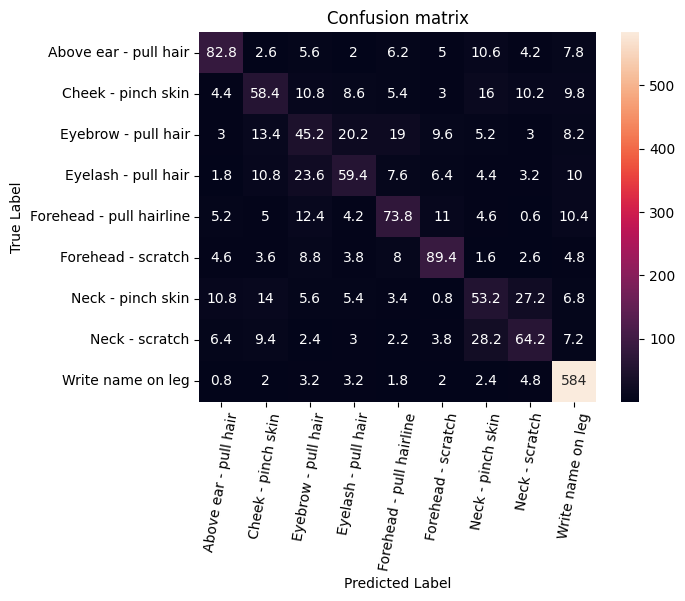

In [77]:
fold = get_avg_fold(folds_score)
# fold = folds_score[2]

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

,feature,importance
20,angular_mag_mean,737.4
21,angular_mag_std,468.6
22,angular_mag_max,389.6


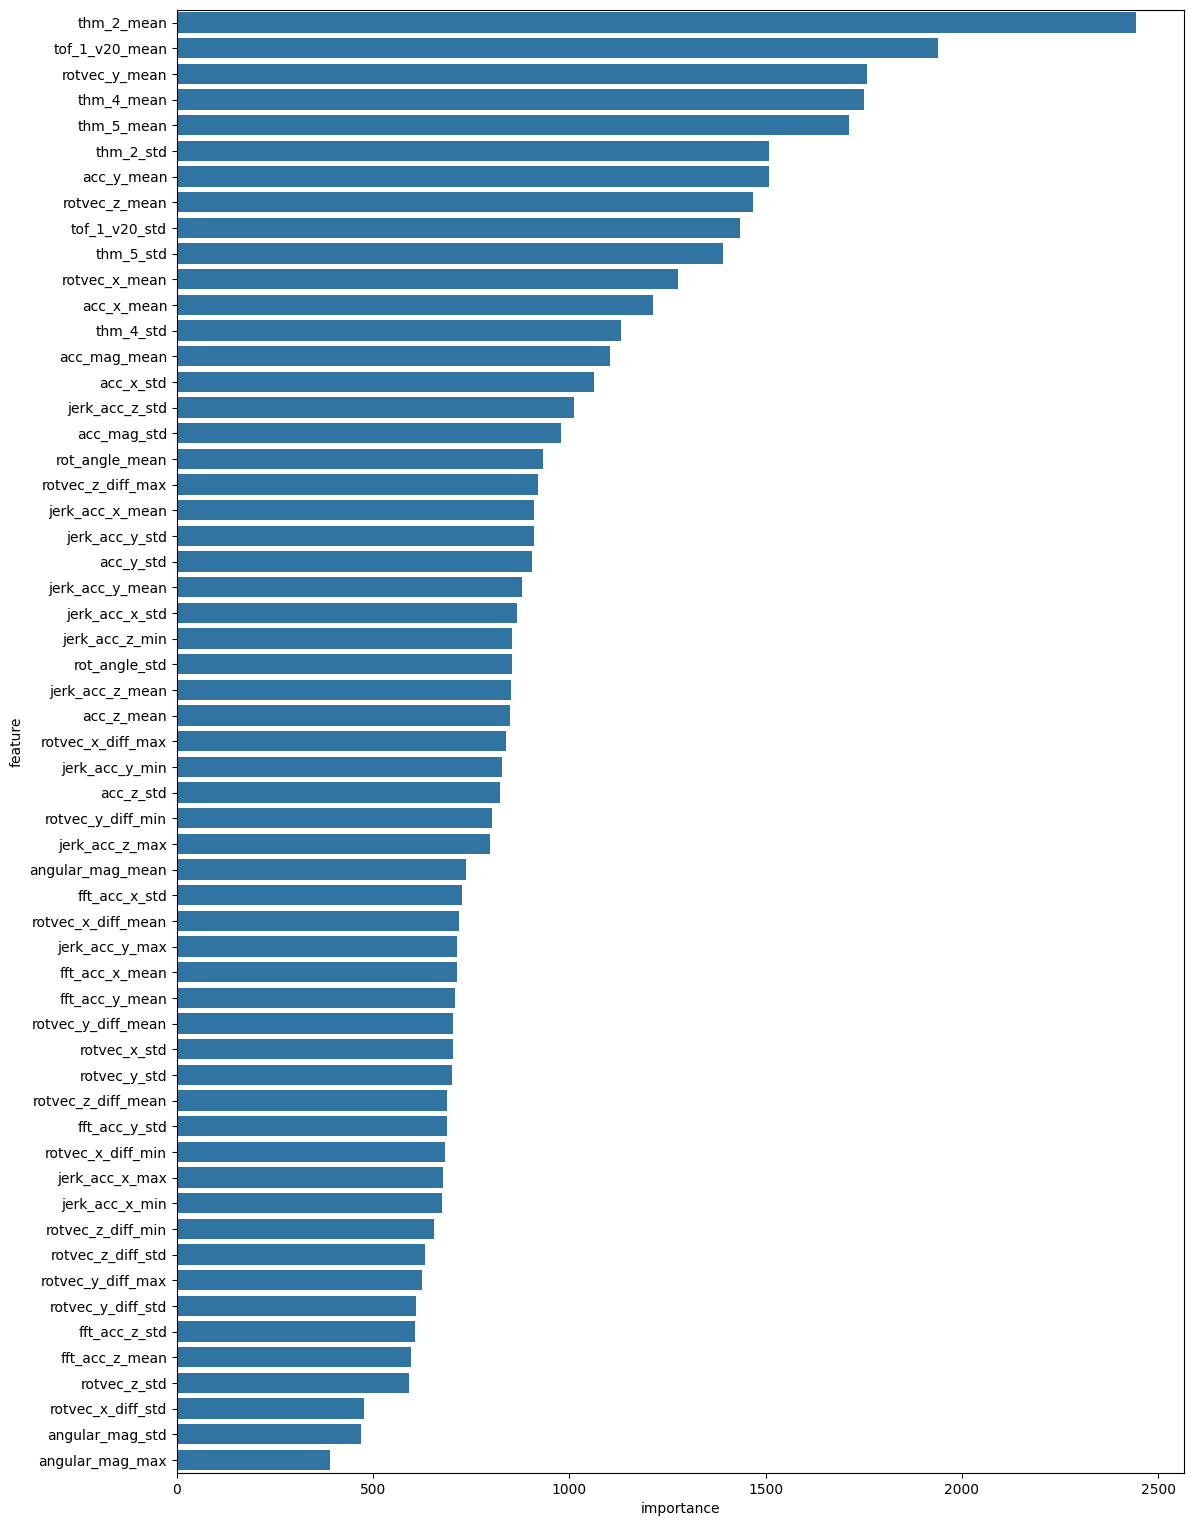

In [80]:
avg_importances =np.mean(importances, axis=0)
col_names = filtered_df.columns.drop(['subject', 'target'])
importance_df = pd.DataFrame({
    'feature': col_names,
    'importance': avg_importances,
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(13, 19))
sns.barplot(importance_df, x='importance', y='feature')
plt.title("")

importance_df[importance_df['feature'].str.contains("angular")]

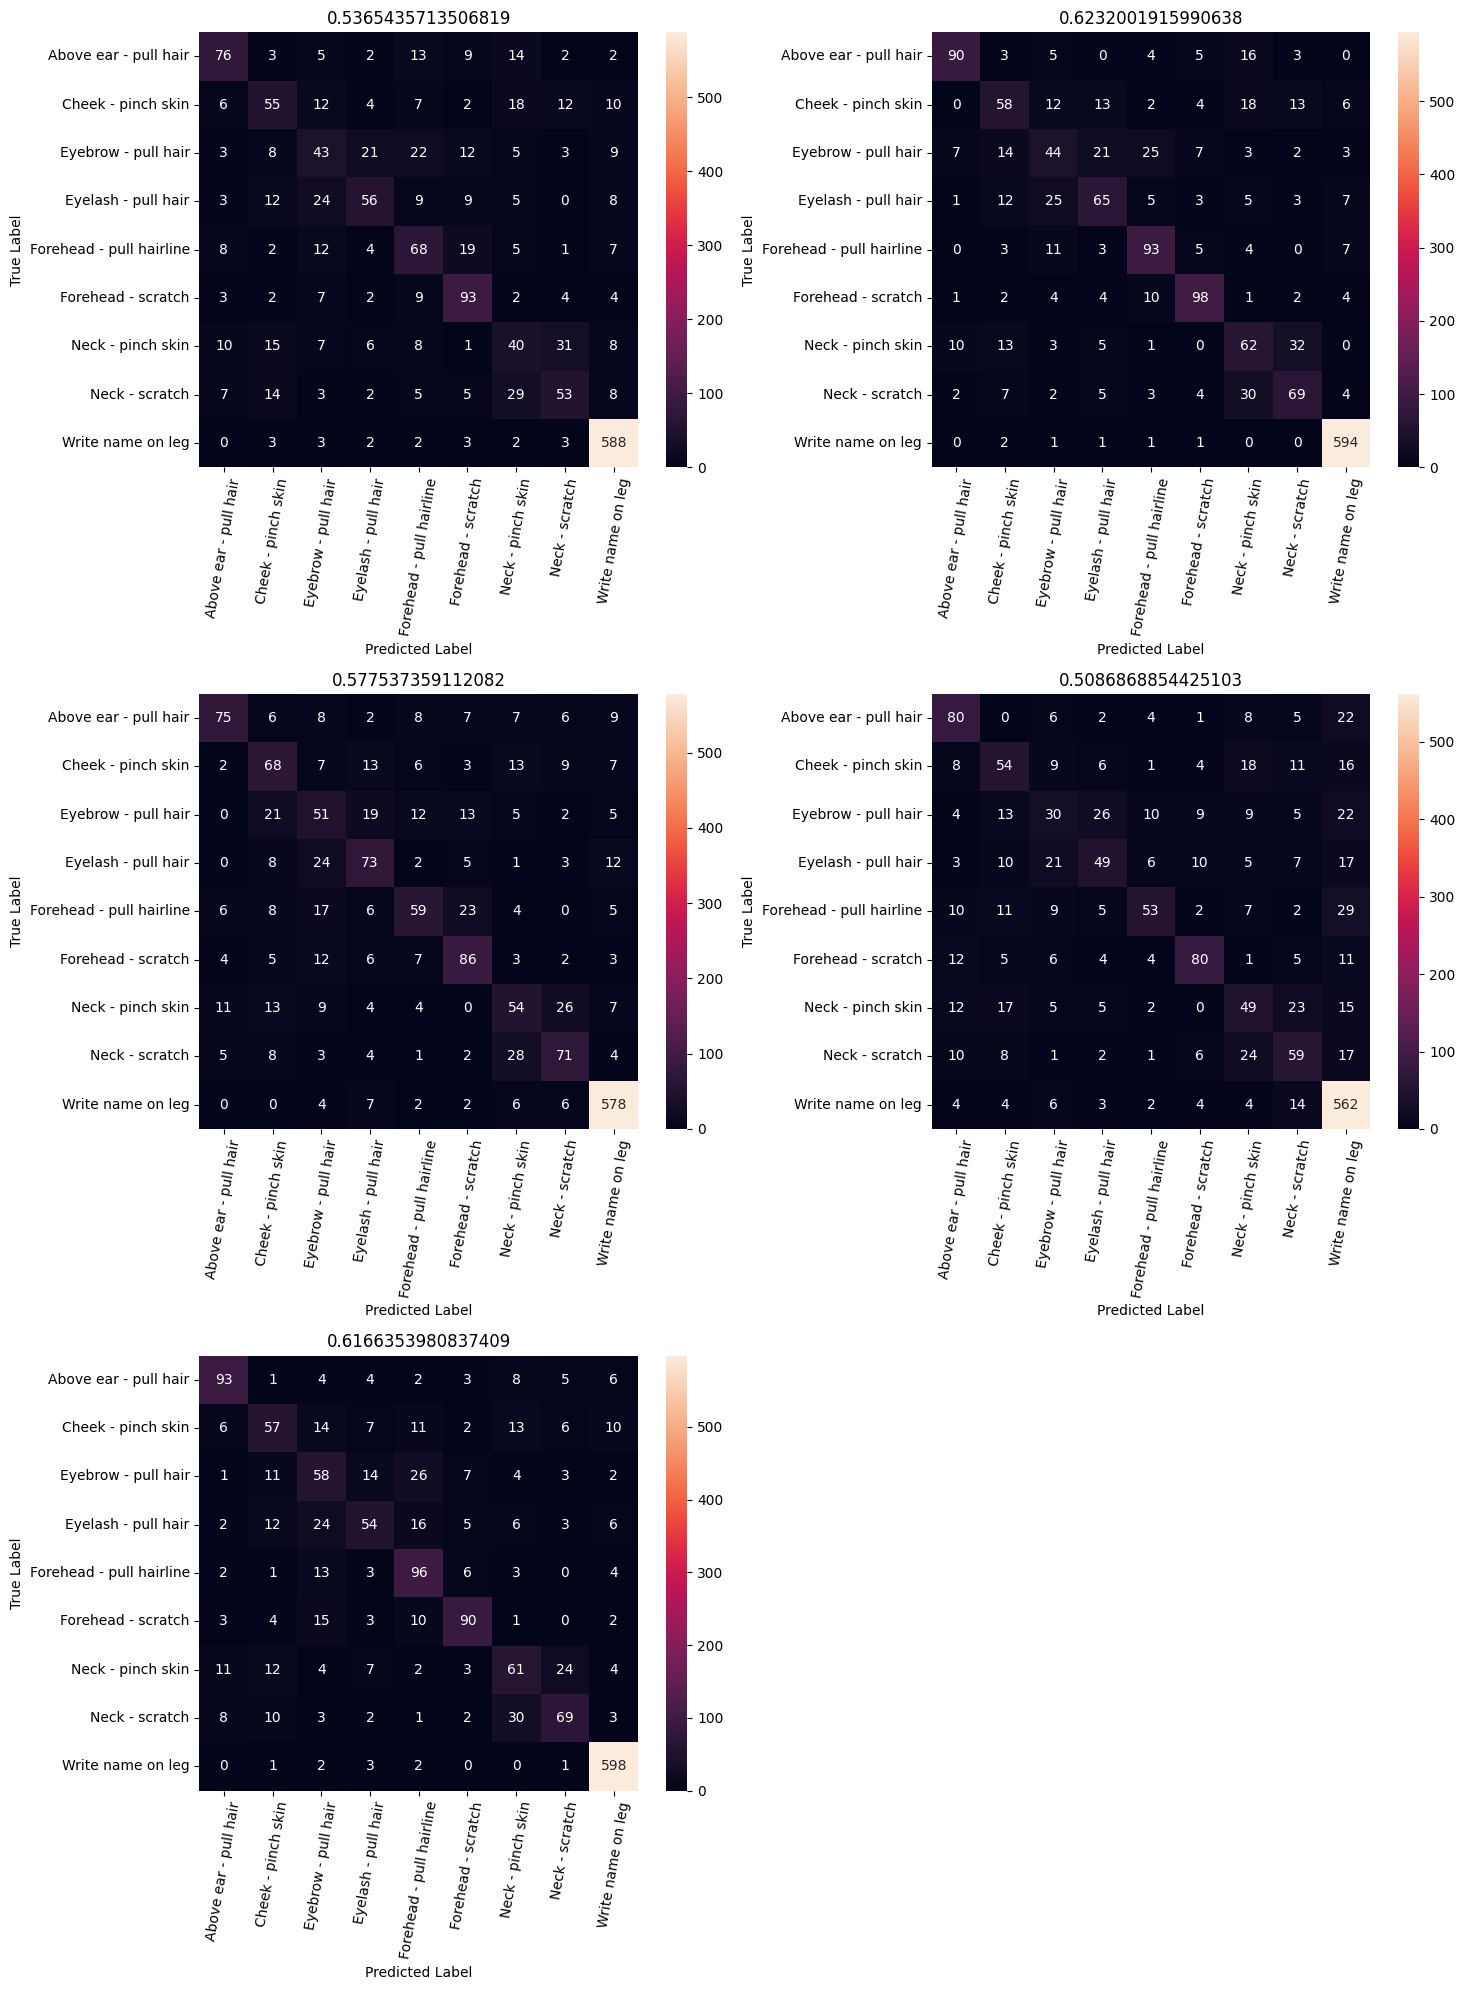

In [79]:
plt.figure(figsize=(15, 20))
for i, fold in enumerate(folds_score, start=1):
    plt.subplot(3, 2, i)
    plot_cm(fold["confusion_matrix"], list(encoder.classes_))
    plt.title(fold['f1_macro'])

plt.tight_layout()
# plt.subplots_adjust(hspace=0.8)

good subjects: ['SUBJ_040733' 'SUBJ_055211' 'SUBJ_059330' 'SUBJ_038023' 'SUBJ_044680'
 'SUBJ_021670' 'SUBJ_008304' 'SUBJ_036450']
bad subjects: ['SUBJ_001430' 'SUBJ_024137' 'SUBJ_061552' 'SUBJ_040106' 'SUBJ_034631'
 'SUBJ_008728' 'SUBJ_042254']


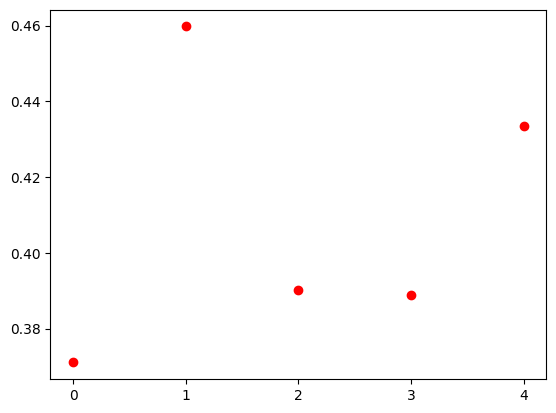

In [55]:
macros = [f["f1_macro"] for f in folds_score]
plt.plot(np.arange(len(macros)), macros, 'ro')
plt.xticks(np.arange(len(macros)))

bad_idx = 2
good_idx = 4

print(f'good subjects: {test_subjects[good_idx]}')
print(f'bad subjects: {test_subjects[bad_idx]}')

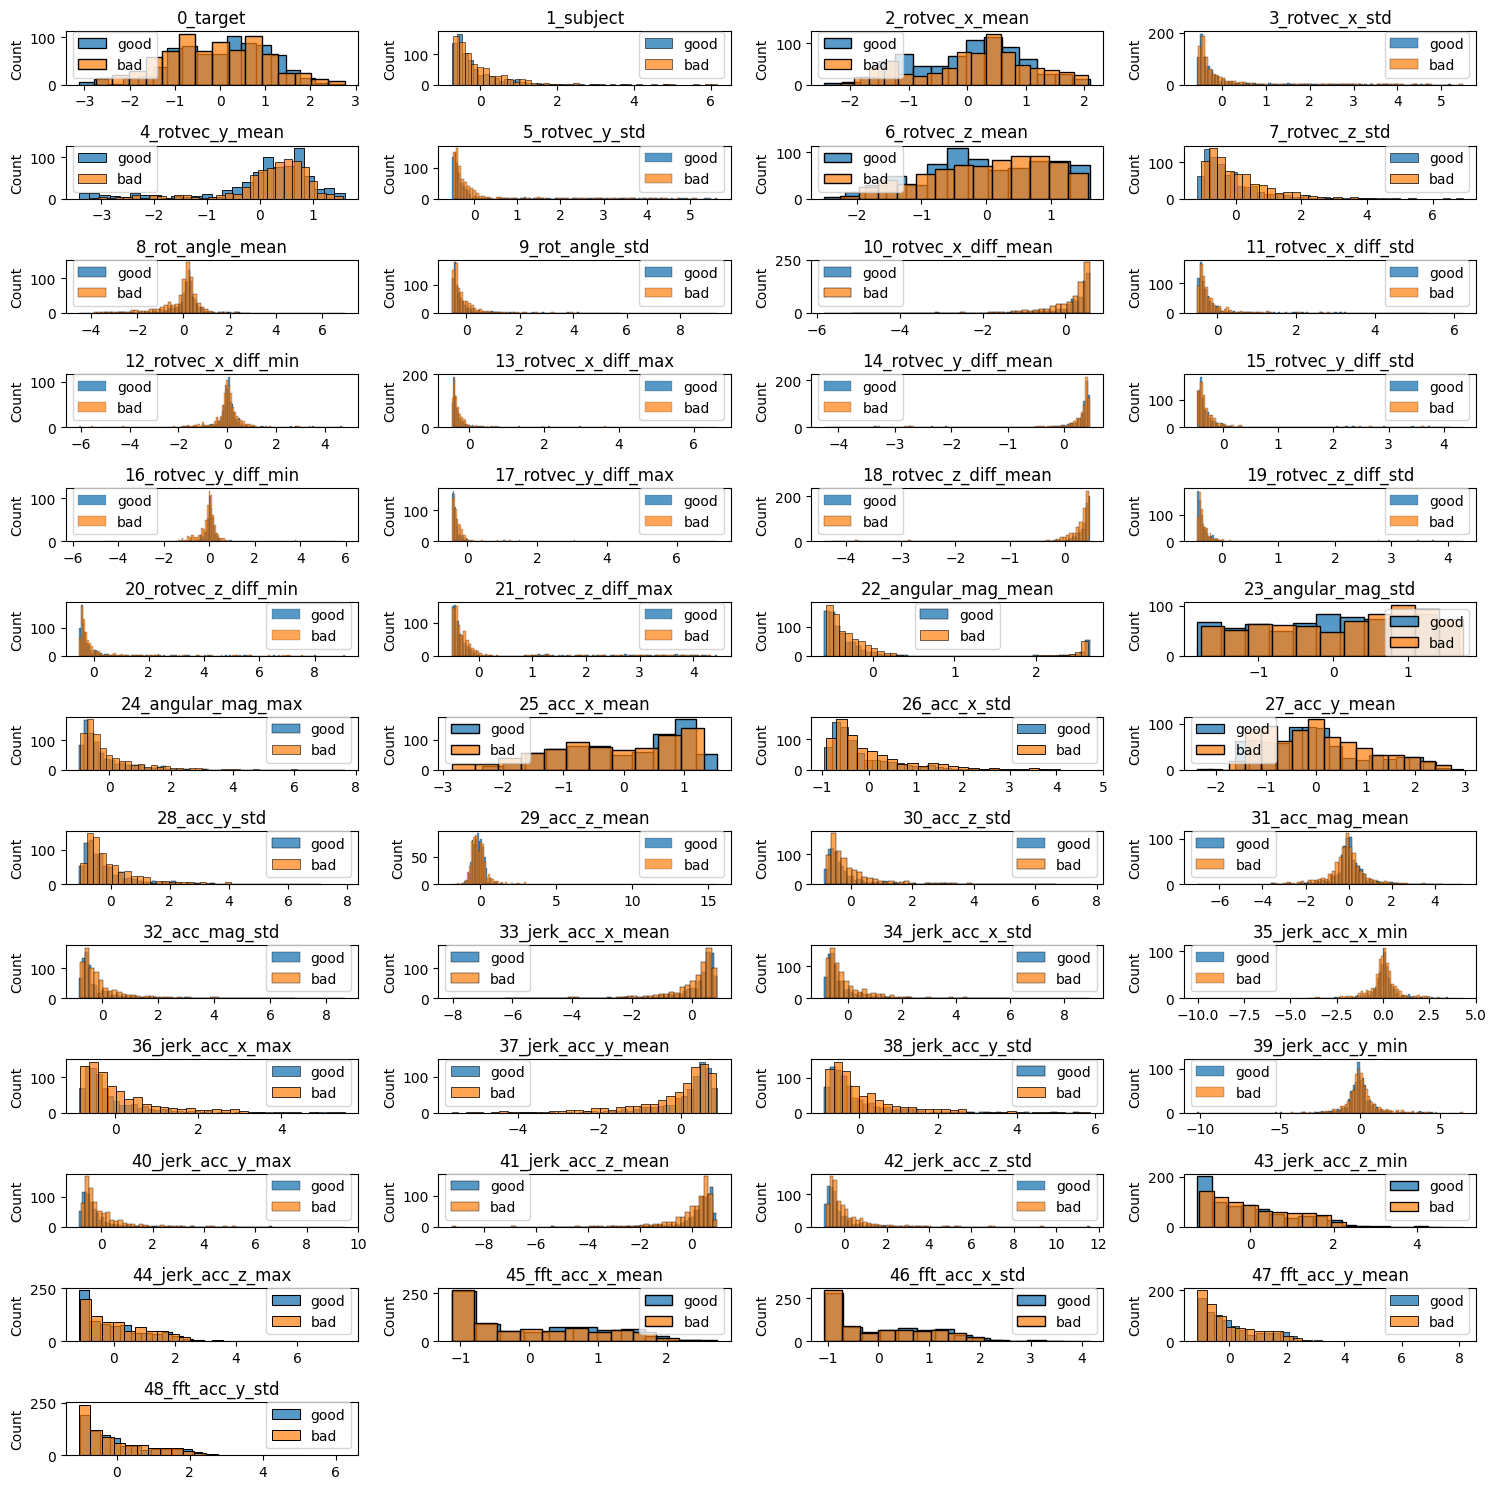

In [50]:
# sub_df = pd.DataFrame(
#     {
#         "value": np.concat([data_good, data_bad]),
#         "fold": ["good"] * len(data_good) + ["bad"] * len(data_bad),
#     }
# )


graph_idx = 1
plt.figure(figsize=(15, 15))
for feature_idx in range(0, X_train_arr[0].shape[1]):
    data_good = X_test_arr[good_idx][:, feature_idx]
    data_bad = X_test_arr[bad_idx][:, feature_idx]

    plt.subplot(13, 4, graph_idx)
    plt.title(f"{feature_idx}_{filtered_df.columns[feature_idx]}")
    sns.histplot(data_good, label="good")
    sns.histplot(data_bad, alpha=0.7, label="bad")
    plt.legend()

    graph_idx += 1

plt.tight_layout()

<Axes: ylabel='Count'>

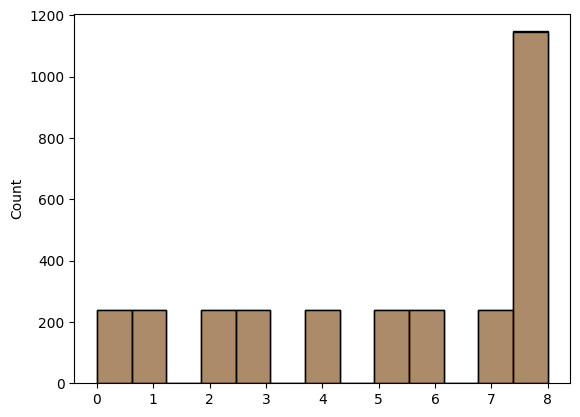

In [53]:
sns.histplot(y_train_arr[good_idx])
sns.histplot(y_train_arr[bad_idx], alpha=0.5)

In [ ]:
# final train model
n_epochs = 400
model = SimpleModel(len(encoder.classes_))

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
